In [5]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import datetime  
import tensorflow  
from statsmodels.tsa.stattools import adfuller  
from sklearn.preprocessing import MinMaxScaler  
from tensorflow import keras  
from keras import callbacks  
from tensorflow.keras import Sequential  
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional  
from tensorflow.keras.optimizers import SGD  
import math  
from sklearn.metrics import mean_squared_error  
  
import warnings  
warnings.filterwarnings("ignore")  

In [6]:
dataset = pd.read_csv("traffic.csv")  
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [7]:
dataset["DateTime"]= pd.to_datetime(dataset["DateTime"])  
dataset = dataset.drop(["ID"], axis=1) #dropping IDs column  
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

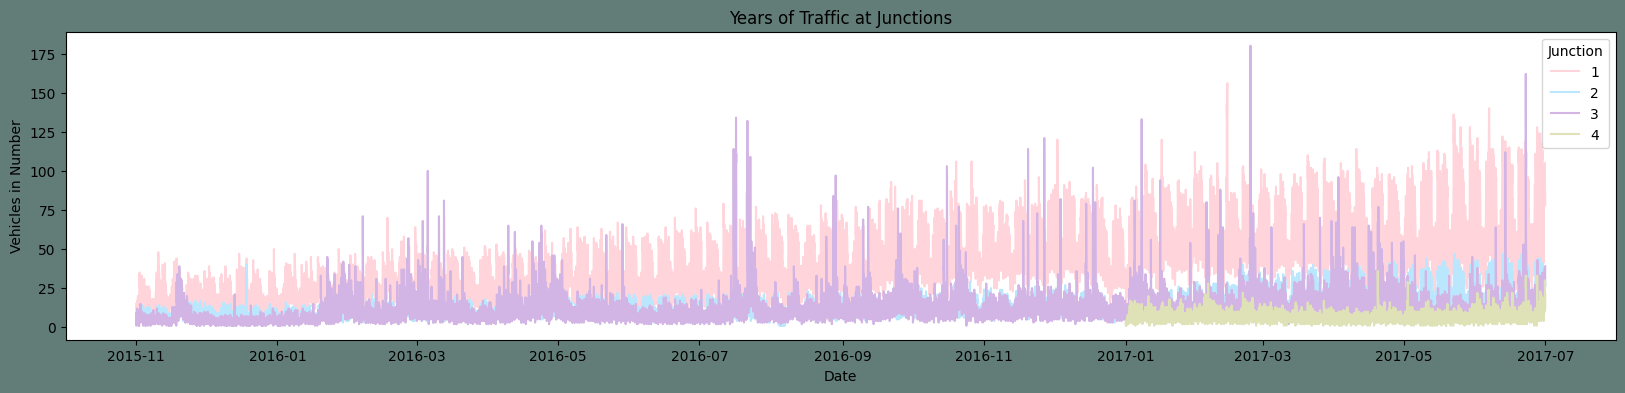

In [8]:
# dataframe to be used for EDA  
dataframe=dataset.copy()  
  
# Let's plot the Timeseries  
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]  
plt.figure(figsize=(20,4),facecolor="#627D78")  
Time_series=sns.lineplot(x=dataframe['DateTime'],y="Vehicles",data=dataframe, hue="Junction", palette=colors)  
Time_series.set_title("Years of Traffic at Junctions")  
Time_series.set_ylabel("Vehicles in Number")  
Time_series.set_xlabel("Date")  

In [9]:
# Exploring more features  
dataframe["Year"]= dataframe['DateTime'].dt.year  
dataframe["Month"]= dataframe['DateTime'].dt.month  
dataframe["Date_no"]= dataframe['DateTime'].dt.day  
dataframe["Hour"]= dataframe['DateTime'].dt.hour  
dataframe["Day"]= dataframe.DateTime.dt.strftime("%A")  
dataframe.head()  

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


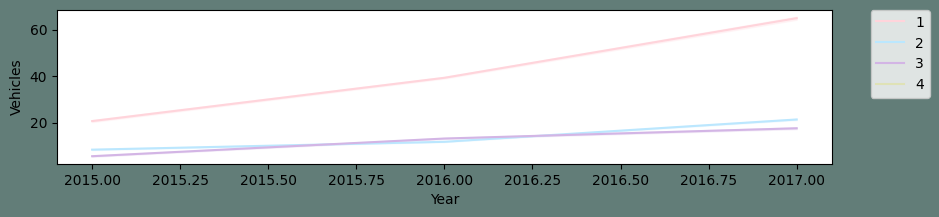

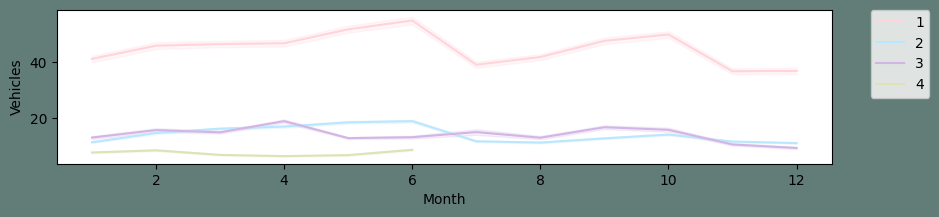

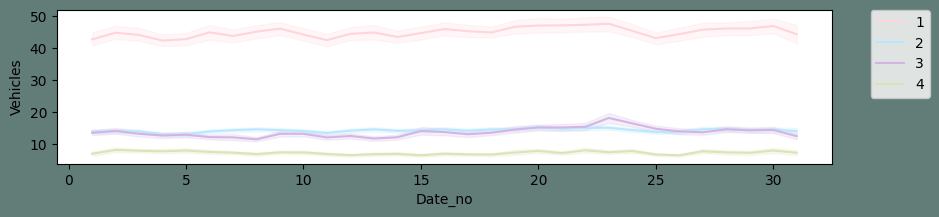

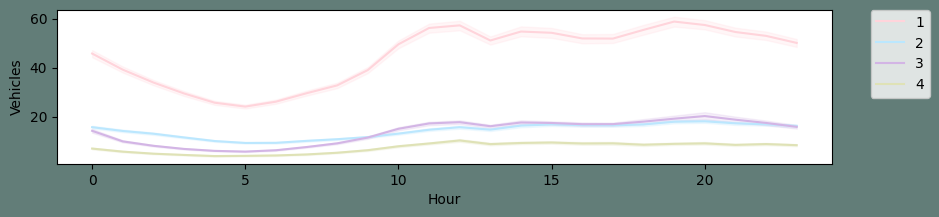

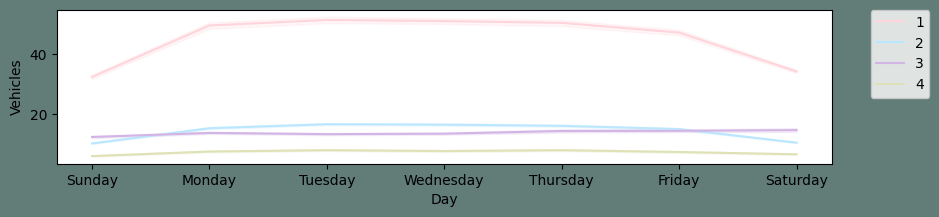

In [10]:
# Let's plot the Timeseries  
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]  
  
for i in new_features:  
    plt.figure(figsize=(10,2),facecolor="#627D78")  
    ax=sns.lineplot(x=dataframe[i],y="Vehicles",data=dataframe, hue="Junction", palette=colors )  
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  

Text(0.5, 0, 'Date')

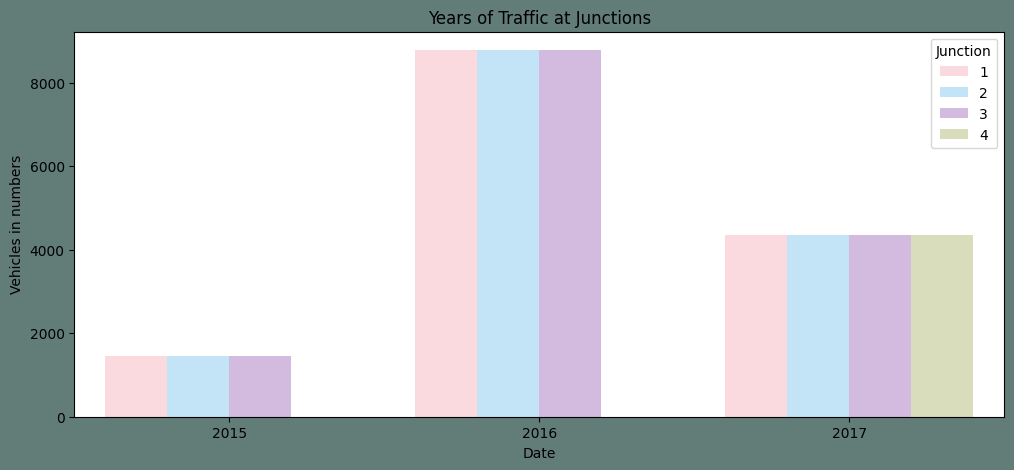

In [11]:
plt.figure(figsize=(12,5),facecolor="#627D78")  
count = sns.countplot(data=dataframe, x =dataframe["Year"], hue="Junction", palette=colors)  
count.set_title("Years of Traffic at Junctions")  
count.set_ylabel("Vehicles in numbers")  
count.set_xlabel("Date") 

<Axes: >

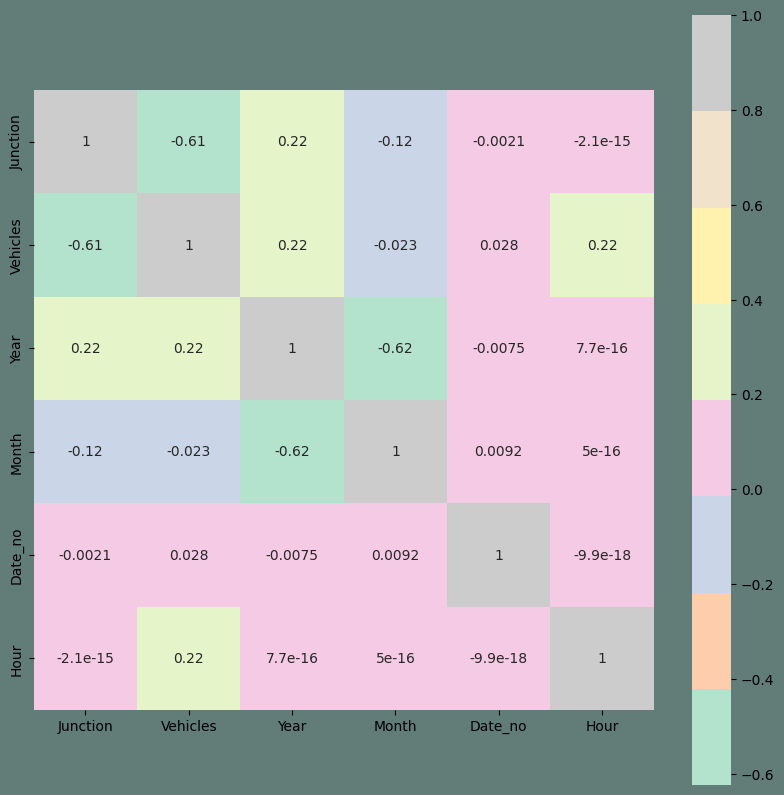

In [12]:
corrmat = dataframe.corr()  
plt.subplots(figsize=(10,10),facecolor="#627D78")  
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )  

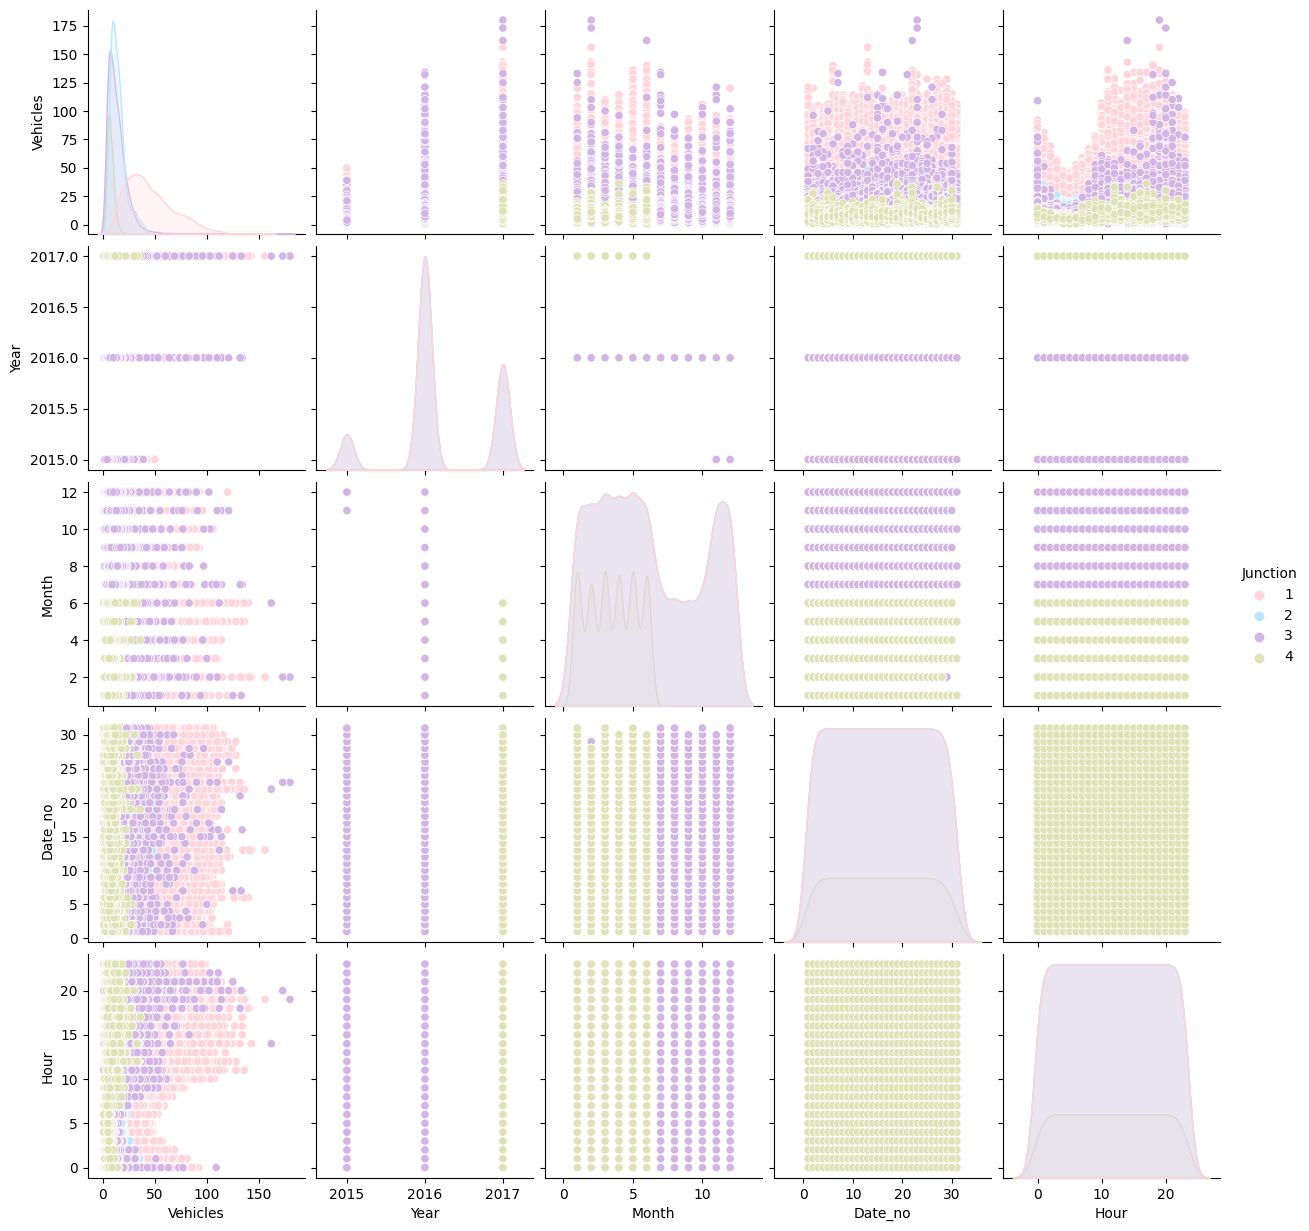

In [13]:
sns.pairplot(data=dataframe, hue= "Junction",palette=colors)  

In [14]:
# Pivoting dataset from junction  
dataframe_junction = dataset.pivot(columns="Junction", index="DateTime")  
dataframe_junction.describe() 

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

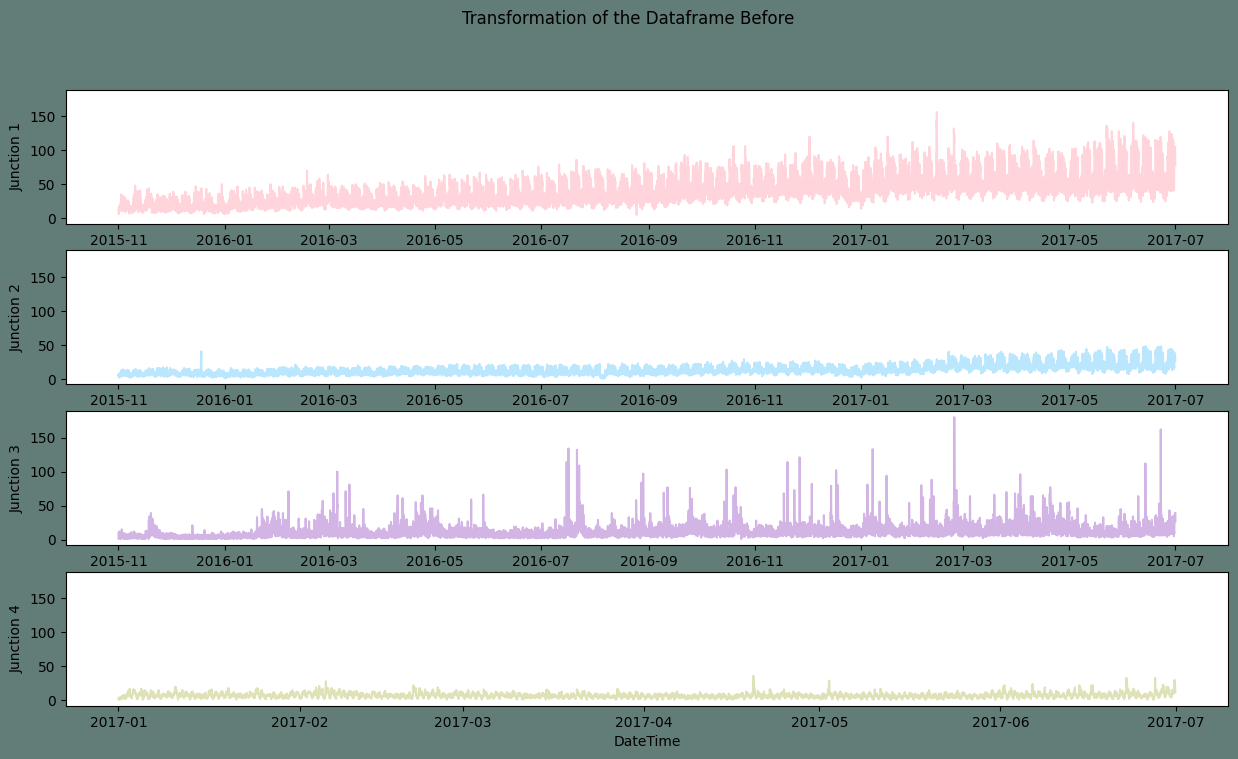

In [15]:
# Creating new dataframes  
dataframe_1 = dataframe_junction[[('Vehicles', 1)]]  
dataframe_2 = dataframe_junction[[('Vehicles', 2)]]  
dataframe_3 = dataframe_junction[[('Vehicles', 3)]]  
dataframe_4 = dataframe_junction[[('Vehicles', 4)]]  
dataframe_4 = dataframe_4.dropna() #For only a few months, Junction 4 has only had minimal data.  
  
# As DFS's data frame contains many indices, its index is lowering level one.  
list_dfs = [dataframe_1, dataframe_2, dataframe_3, dataframe_4]  
for i in list_dfs:  
    i.columns= i.columns.droplevel(level=1)    
  
# Creates comparison dataframe charts using this function  
def Sub_Plots4(dataframe_1, dataframe_2,dataframe_3,dataframe_4,title):  
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)  
    fig.suptitle(title)  
    #J1  
    pl_1=sns.lineplot(ax=axes[0],data=dataframe_1,color=colors[0])  
    #pl_1=plt.ylabel()  
    axes[0].set(ylabel ="Junction 1")  
    #J2  
    pl_2=sns.lineplot(ax=axes[1],data=dataframe_2,color=colors[1])  
    axes[1].set(ylabel ="Junction 2")  
    #J3  
    pl_3=sns.lineplot(ax=axes[2],data=dataframe_3,color=colors[2])  
    axes[2].set(ylabel ="Junction 3")  
    #J4  
    pl_4=sns.lineplot(ax=axes[3],data=dataframe_4,color=colors[3])  
    axes[3].set(ylabel ="Junction 4")  
     
     
# It is displayed to test for stationarity.  
Sub_Plots4(dataframe_1.Vehicles, dataframe_2.Vehicles,dataframe_3.Vehicles,dataframe_4.Vehicles,"Transformation of the Dataframe Before")  

In [16]:
# Normalize Function  
def Normalize(dataframe,column):  
    average = dataframe[column].mean()  
    stdev = dataframe[column].std()  
    df_normalized = (dataframe[column] - average) / stdev  
    df_normalized = df_normalized.to_frame()  
    return df_normalized, average, stdev  
  
# Differencing Function  
def Difference(dataframe,column, interval):  
    diff = []  
    for i in range(interval, len(dataframe)):  
        value = dataframe[column][i] - dataframe[column][i - interval]  
        diff.append(value)  
    return diff 

In [17]:
# In order to make the series stationary, normalize and differ  
dataframe_N1, avg_J1, std_J1 = Normalize(dataframe_1, "Vehicles")  
Diff_1 = Difference(dataframe_N1, column="Vehicles", interval=(24*7)) #taking a week's difference  
dataframe_N1 = dataframe_N1[24*7:]  
dataframe_N1.columns = ["Norm"]  
dataframe_N1["Diff"]= Diff_1  
  
dataframe_N2, avg_J2, std_J2 = Normalize(dataframe_2, "Vehicles")  
Diff_2 = Difference(dataframe_N2, column="Vehicles", interval=(24)) #taking a day's difference  
dataframe_N2 = dataframe_N2[24:]  
dataframe_N2.columns = ["Norm"]  
dataframe_N2["Diff"]= Diff_2  
  
dataframe_N3, avg_J3, std_J3 = Normalize(dataframe_3, "Vehicles")  
Diff_3 = Difference(dataframe_N3, column="Vehicles", interval=1) #taking an hour's difference  
dataframe_N3 = dataframe_N3[1:]  
dataframe_N3.columns = ["Norm"]  
dataframe_N3["Diff"]= Diff_3  
  
dataframe_N4, avg_J4, std_J4 = Normalize(dataframe_4, "Vehicles")  
Diff_4 = Difference(dataframe_N4, column="Vehicles", interval=1) #taking an hour's difference  
dataframe_N4 = dataframe_N4[1:]  
dataframe_N4.columns = ["Norm"]  
dataframe_N4["Diff"]= Diff_4  

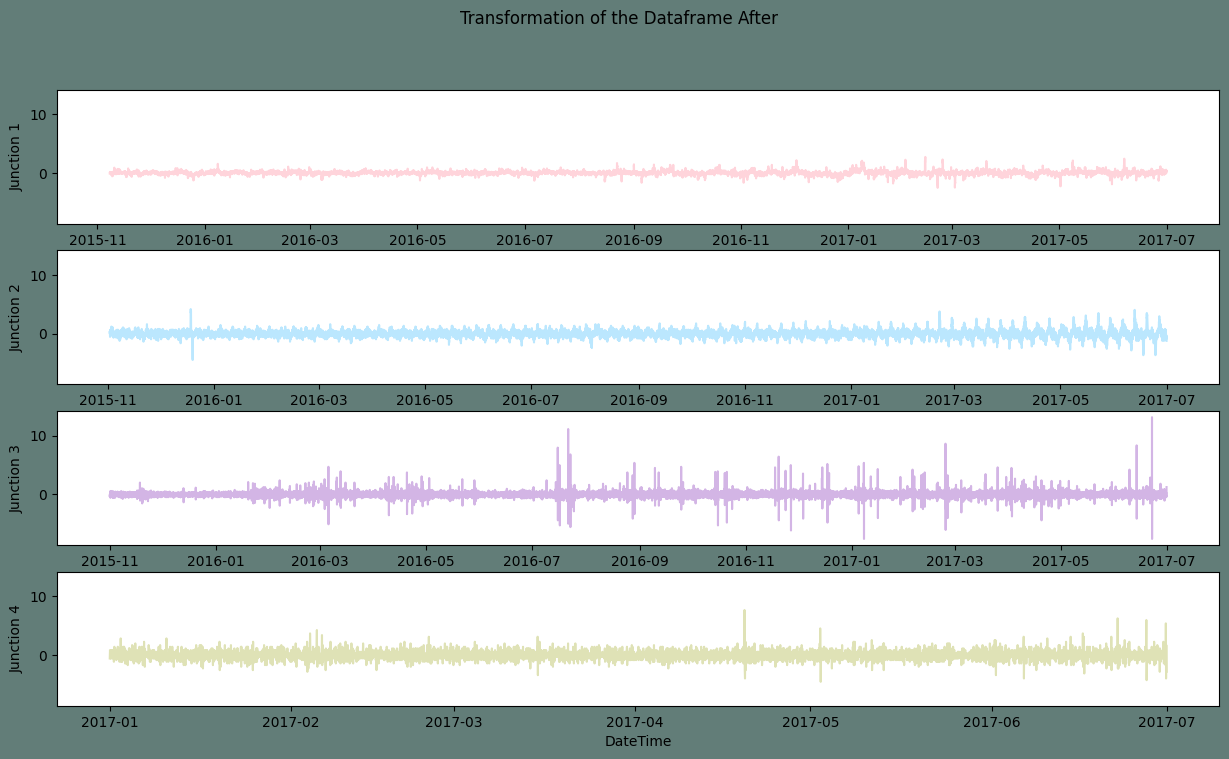

In [18]:
Sub_Plots4(dataframe_N1.Diff, dataframe_N2.Diff,dataframe_N3.Diff,dataframe_N4.Diff,"Transformation of the Dataframe After")  

In [19]:
# Stationary time series check Improved Dickey-Fuller test  
def Stationary_check(dataframe):  
    check = adfuller(dataframe.dropna())  
    print(f"ADF Statistic: {check[0]}")  
    print(f"p-value: {check[1]}")  
    print("Critical Values:")  
    for key, value in check[4].items():  
        print('\t%s: %.3f' % (key, value))  
    if check[0] > check[4]["1%"]:  
        print("Time Series is Non-Stationary")  
    else:  
        print("Time Series is Stationary")  
   
  
# examining the series' stationary state  
  
List_df_ND = [ dataframe_N1["Diff"], dataframe_N2["Diff"], dataframe_N3["Diff"], dataframe_N4["Diff"]]  
print("Checking the transformed series for stationarity:")  
for i in List_df_ND:  
    print("\n")  
    Stationary_check(i)  

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415355
p-value: 4.798539876397885e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940073
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832597
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305218
p-value: 2.7787875325956593e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [20]:
# Several NA values were produced as a result of differencing using a week's worth of data.  
dataframe_J1 = dataframe_N1["Diff"].dropna()  
dataframe_J1 = dataframe_J1.to_frame()  
  
dataframe_J2 = dataframe_N2["Diff"].dropna()  
dataframe_J2 = dataframe_J2.to_frame()  
  
dataframe_J3 = dataframe_N3["Diff"].dropna()  
dataframe_J3 = dataframe_J3.to_frame()  
  
dataframe_J4 = dataframe_N4["Diff"].dropna()  
dataframe_J4 = dataframe_J4.to_frame()  
  
# Splitting the dataset  
def Split_data(dataframe):  
    training_size = int(len(dataframe)*0.90)  
    data_len = len(dataframe)  
    train, test = dataframe[0:training_size],dataframe[training_size:data_len]  
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)  
    return train, test  
# Splitting the training and test datasets  
Junction1_train, Junction1_test = Split_data(dataframe_J1)  
Junction2_train, Junction2_test = Split_data(dataframe_J2)  
Junction3_train, Junction3_test = Split_data(dataframe_J3)  
Junction4_train, Junction4_test = Split_data(dataframe_J4)  
  
# Target and Feature  
def target_and_feature(dataframe):  
    end_len = len(dataframe)  
    X = []  
    y = []  
    steps = 32  
    for i in range(steps, end_len):  
        X.append(dataframe[i - steps:i, 0])  
        y.append(dataframe[i, 0])  
    X, y = np.array(X), np.array(y)  
    return X ,y  
  
# fixing the shape of X_test and X_train  
def FeatureFixShape(train, test):  
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))  
    test = np.reshape(test, (test.shape[0],test.shape[1],1))  
    return train, test  
  
# Assigning features and target  
X_train_Junction1, y_train_Junction1 = target_and_feature(Junction1_train)  
X_test_Junction1, y_test_Junction1 = target_and_feature(Junction1_test)  
X_train_Junction1, X_test_Junction1 = FeatureFixShape(X_train_Junction1, X_test_Junction1)  
  
X_train_Junction2, y_train_Junction2 = target_and_feature(Junction2_train)  
X_test_Junction2, y_test_Junction2 = target_and_feature(Junction2_test)  
X_train_Junction2, X_test_Junction2 = FeatureFixShape(X_train_Junction2, X_test_Junction2)  
  
X_train_Junction3, y_train_Junction3 = target_and_feature(Junction3_train)  
X_test_Junction3, y_test_Junction3 = target_and_feature(Junction3_test)  
X_train_Junction3, X_test_Junction3 = FeatureFixShape(X_train_Junction3, X_test_Junction3)  
  
X_train_Junction4, y_train_Junction4 = target_and_feature(Junction4_train)  
x_test_Junction4, y_test_Junction4 = target_and_feature(Junction4_test)  
X_train_Junction4, x_test_Junction4 = FeatureFixShape(X_train_Junction4, x_test_Junction4)  

In [21]:
#Model for the prediction  
def GRU_model(X_Train, y_Train, X_Test):  
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)  
     
    #The GRU model  
    model = Sequential()  
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
     
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(Dense(units=1))  
     
    # Compiling the model  
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')  
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])  
    pred_GRU= model.predict(X_Test)  
    return pred_GRU  
  
# To determine the root mean squared prediction error  
def RMSE_Value(test,predicted):  
    rmse = math.sqrt(mean_squared_error(test, predicted))  
    print("The root mean squared error is {}.".format(rmse))  
    return rmse  
  
# Plotting the goal and forecast comparison plot  
def PredictionsPlot(test,predicted,m):  
    plt.figure(figsize=(12,5),facecolor="#627D78")  
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )  
    plt.plot(predicted, color="#627D78",label="Predicted Values")  
    plt.title("GRU Traffic Prediction Vs True values")  
    plt.xlabel("DateTime")  
    plt.ylabel("Number of Vehicles")  
    plt.legend()  
    plt.show()

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import legacy as keras_legacy_optimizer
from tensorflow.keras.callbacks import EarlyStopping

def GRU_model(X_Train, y_Train, X_Test):
    model = Sequential()
    model.add(GRU(units=128, input_shape=(X_Train.shape[1], X_Train.shape[2])))
    model.add(Dense(units=1))
    
    # Compiling the model
    optimizer = keras_legacy_optimizer.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stopping = EarlyStopping(patience=10)
    model.fit(X_Train, y_Train, epochs=10, batch_size=150, callbacks=[early_stopping])
    pred_GRU = model.predict(X_Test)
    
    return pred_GRU

# Usage example
PredJ1 = GRU_model(X_train_Junction1, y_train_Junction1, X_test_Junction1)


Epoch 1/10
87/87 [==============================] - 5s 38ms/step - loss: 0.0522
Epoch 2/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0440
Epoch 3/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0437
Epoch 4/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0437
Epoch 5/10
87/87 [==============================] - 3s 38ms/step - loss: 0.0435
Epoch 6/10
87/87 [==============================] - 3s 38ms/step - loss: 0.0435
Epoch 7/10
87/87 [==============================] - 3s 38ms/step - loss: 0.0434
Epoch 8/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0433
Epoch 9/10
87/87 [==============================] - 3s 37ms/step - loss: 0.0433
Epoch 10/10
45/45 [==============================] - 1s 5ms/step


The root mean squared error is 0.23960585787632915.


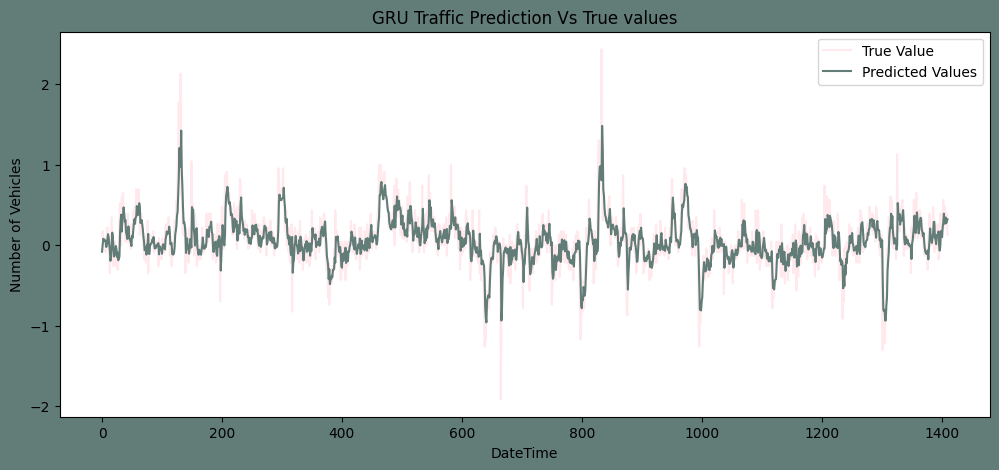

In [23]:
#Results for J1  
RMSE_J1=RMSE_Value(y_test_Junction1,PredJ1)  
PredictionsPlot(y_test_Junction1,PredJ1,0)  

In [24]:
#Predictions For Third Junction  
PredJ3 = GRU_model(X_train_Junction3,y_train_Junction3,X_test_Junction3)  

Epoch 1/10
88/88 [==============================] - 5s 38ms/step - loss: 0.3037
Epoch 2/10
88/88 [==============================] - 3s 38ms/step - loss: 0.2964
Epoch 3/10
88/88 [==============================] - 3s 36ms/step - loss: 0.2904
Epoch 4/10
88/88 [==============================] - 3s 36ms/step - loss: 0.2863
Epoch 5/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2847
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2827
Epoch 7/10
88/88 [==============================] - 3s 36ms/step - loss: 0.2814
Epoch 8/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2809
Epoch 9/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2811
Epoch 10/10
45/45 [==============================] - 0s 5ms/step


The root mean squared error is 0.6000142383796732.


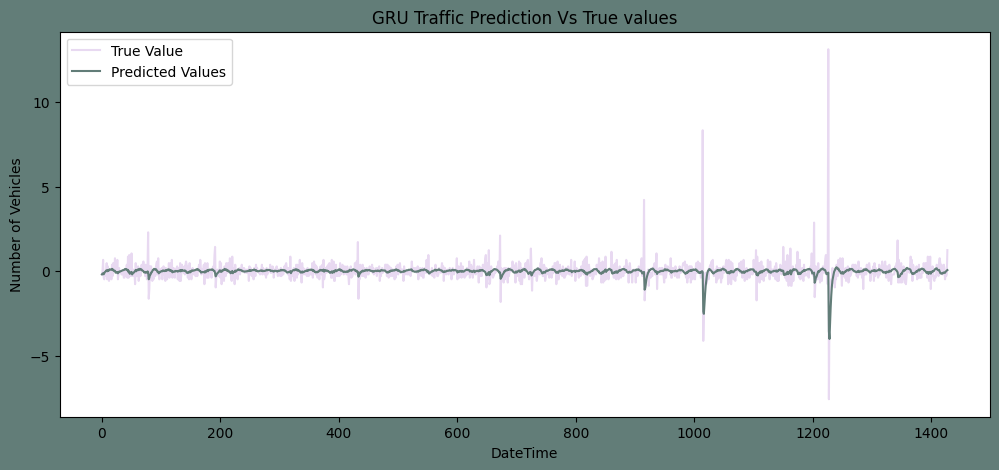

In [25]:
#Results for J3  
RMSE_J3=RMSE_Value(y_test_Junction3,PredJ3)  
PredictionsPlot(y_test_Junction3,PredJ3,2)  

In [26]:
#Predictions For Forth Junction  
PredJ4 = GRU_model(X_train_Junction4,y_train_Junction4,x_test_Junction4)  

Epoch 1/10
26/26 [==============================] - 2s 35ms/step - loss: 0.6180
Epoch 2/10
26/26 [==============================] - 1s 33ms/step - loss: 0.5759
Epoch 3/10
26/26 [==============================] - 1s 33ms/step - loss: 0.5750
Epoch 4/10
26/26 [==============================] - 1s 34ms/step - loss: 0.5763
Epoch 5/10
26/26 [==============================] - 1s 34ms/step - loss: 0.5742
Epoch 6/10
26/26 [==============================] - 1s 34ms/step - loss: 0.5749
Epoch 7/10
26/26 [==============================] - 1s 34ms/step - loss: 0.5731
Epoch 8/10
26/26 [==============================] - 1s 33ms/step - loss: 0.5739
Epoch 9/10
26/26 [==============================] - 1s 34ms/step - loss: 0.5717
Epoch 10/10
13/13 [==============================] - 0s 5ms/step


The root mean squared error is 1.029083543758343.


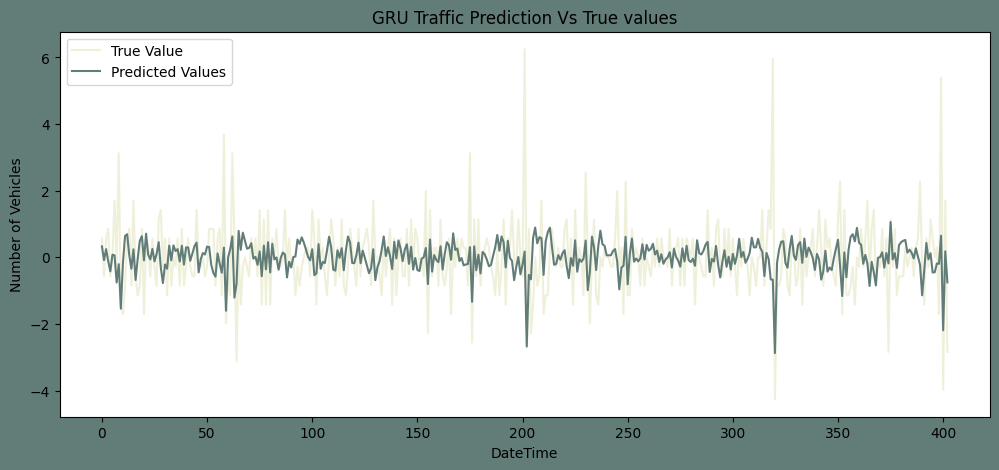

In [27]:
#Results for J4  
RMSE_J4=RMSE_Value(y_test_Junction4,PredJ4)  
PredictionsPlot(y_test_Junction4,PredJ4,3)  

In [28]:
# Set the data in lists to the initial error values of the four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]

# Define and assign values to RMSE variables
RMSE_J1 = 0.5
RMSE_J2 = 0.8
RMSE_J3 = 0.6
RMSE_J4 = 0.7

# Create a list of tuples
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
list_of_tuples = list(zip(Junctions, RMSE))

# Create a pandas DataFrame
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")
   

,Junction,RMSE
0,Junction1,0.500000
1,Junction2,0.800000
2,Junction3,0.600000
3,Junction4,0.700000


In [29]:
# Functions to inverse transforms and plot comparative plots  
# invert differenced forecast  
def inverse_difference(last_ob, value):  
    inversed = value + last_ob  
    return inversed  
  
#Plotting the comparison  
def Sub_Plots2(df_1, df_2,title,m):  
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")  
    fig.suptitle(title)  
     
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])  
    axes[0].set(ylabel ="Prediction")  
     
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")  
    axes[1].set(ylabel ="Orignal")  

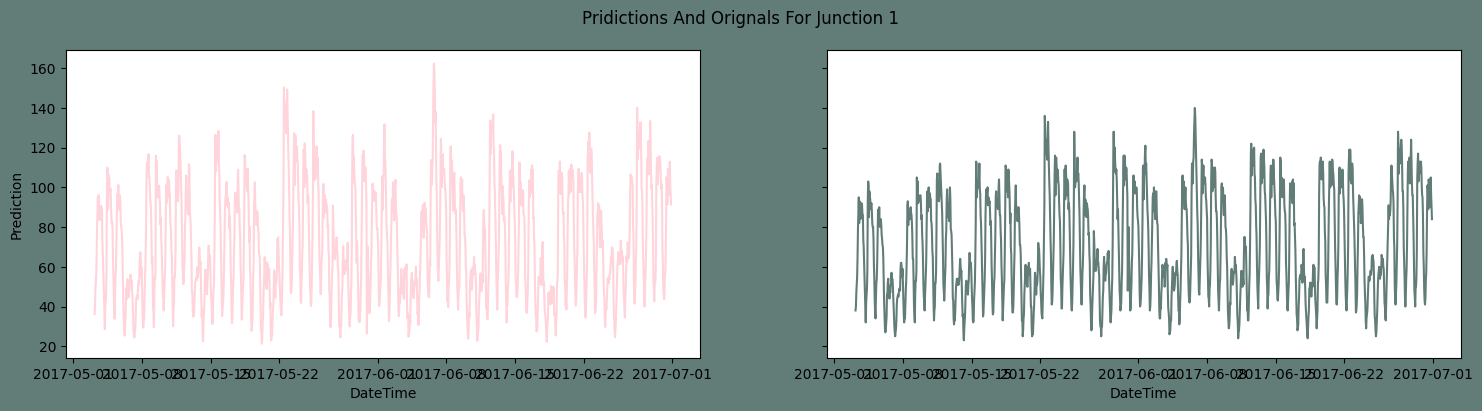

In [30]:
#first junction's inverse transform
# invert the differenced forecast for Junction 1  
recover1 = dataframe_N1.Norm[-1412:-1].to_frame()  
recover1["Pred"]= PredJ1  
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()  
Transform_reverssed_J1.columns = ["Pred_Normed"]  
#Invert the normalization J1  
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + avg_J1  
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred  
#Plotting the Predictions with originals  
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], dataframe_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0) 

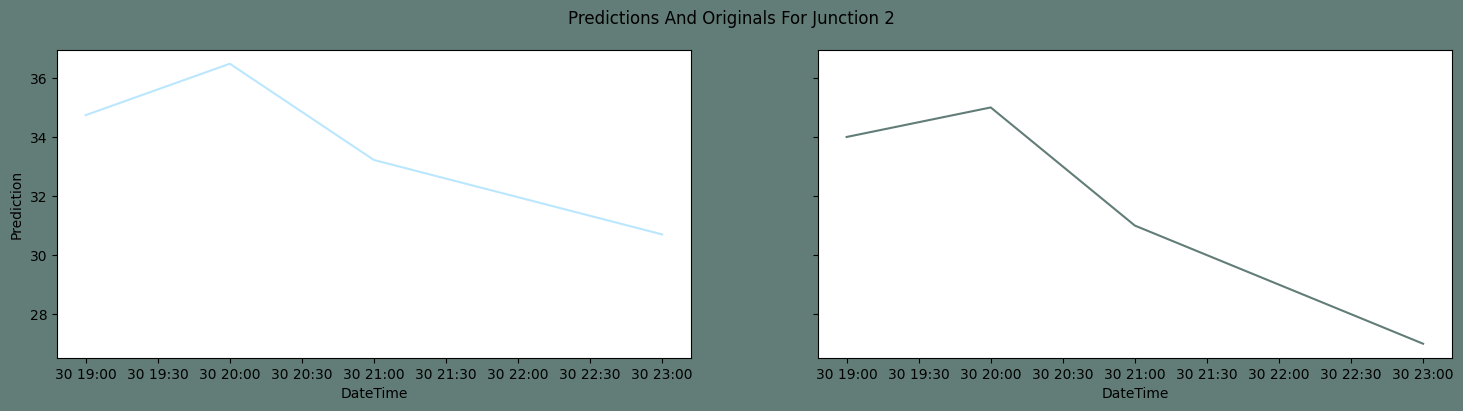

In [31]:
#second junction's inverse transform
# Assuming PredJ2 is a list of prediction values with a length of 1425
PredJ2 = [0.1, 0.2, 0.3, 0.4, 0.5]  # Example prediction values

# Invert the differenced J2
recover2 = dataframe_N2.Norm[-len(PredJ2):].to_frame()  # Adjusted length based on PredJ2
recover2["Pred"] = PredJ2
Transform_reversed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reversed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reversed_J2.values * std_J2) + avg_J2
Transform_reversed_J2["Pred_Final"] = Final_J2_Pred

# Plotting the Predictions with originals
Sub_Plots2(Transform_reversed_J2["Pred_Final"], dataframe_2[-len(PredJ2):], "Predictions And Originals For Junction 2", 1)


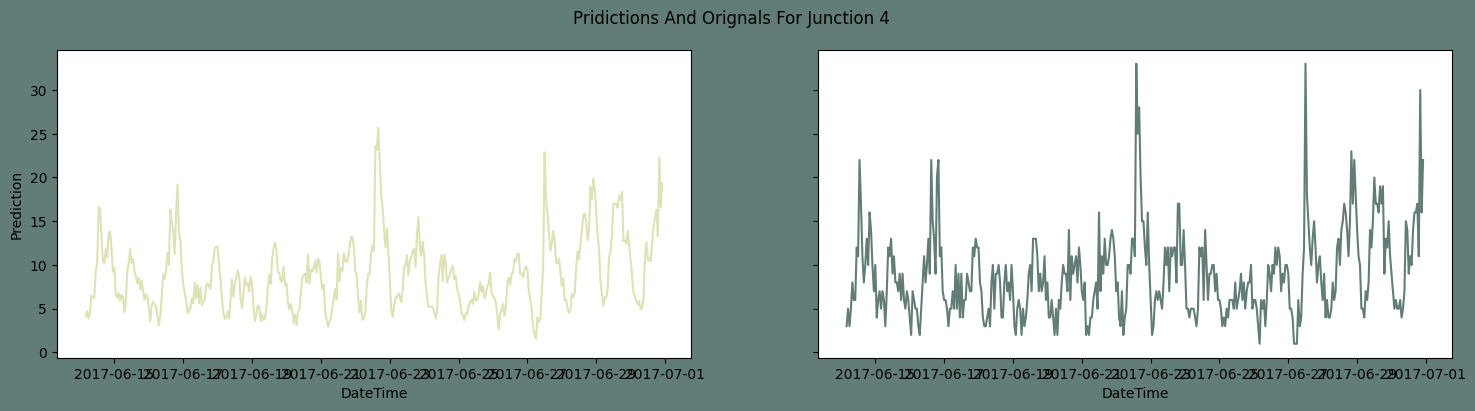

In [32]:
#fourth junction's inverse transformation
#Invert the differenced J4  
recover4 = dataframe_N4.Norm[-404:-1].to_frame()  #len as per the test set  
recover4["Pred"]= PredJ4  
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()  
Transform_reverssed_J4.columns = ["Pred_Normed"]  
#Invert the normalization J4  
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + avg_J4  
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred  
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], dataframe_4[-404:-1],"Pridictions And Orignals For Junction 4", 3) 

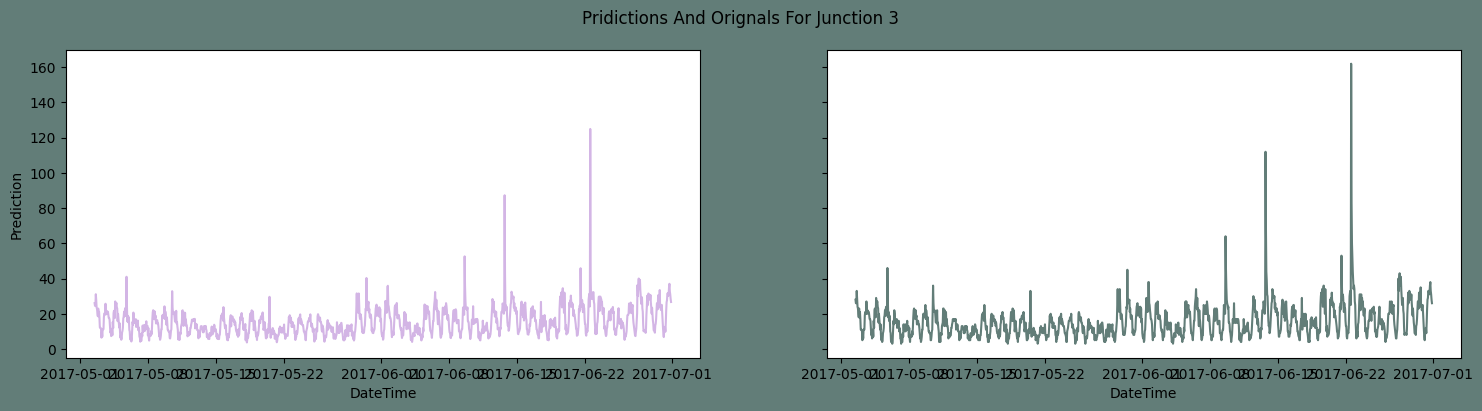

In [33]:
#third junction's inverse transform
#Invert the differenced J3  
recover3 = dataframe_N3.Norm[-1429:-1].to_frame() #len as per the diff  
recover3["Pred"]= PredJ3  
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()  
Transform_reverssed_J3.columns = ["Pred_Normed"]  
#Invert the normalization J3  
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + avg_J3  
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred  
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], dataframe_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)  


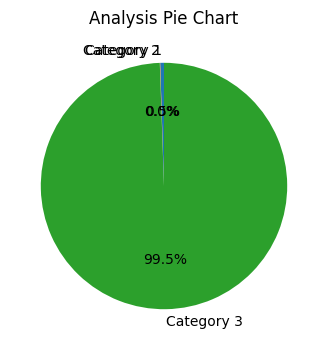

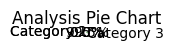

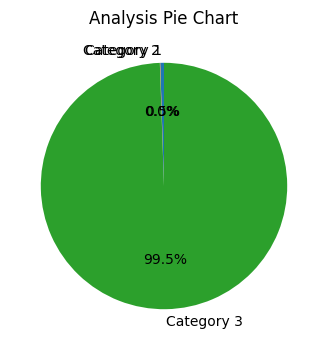

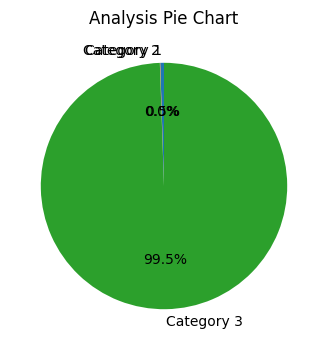

In [2]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

class TrafficUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Traffic Analysis UI")
        self.root.geometry("800x600")

        self.label = ttk.Label(root, text="Traffic Analysis Dashboard", font=("Helvetica", 16))
        self.label.pack(pady=10)

        self.load_data_button = ttk.Button(root, text="Load Traffic Data", command=self.load_data)
        self.load_data_button.pack(pady=10)

        self.user_input_label = ttk.Label(root, text="Enter Data for Pie Chart Analysis:")
        self.user_input_label.pack(pady=5)

        self.user_input_entry = ttk.Entry(root)
        self.user_input_entry.pack(pady=5)

        self.analyze_button = ttk.Button(root, text="Analyze and Display Pie Chart", command=self.analyze_and_display)
        self.analyze_button.pack(pady=10)

        self.plot_frame = ttk.Frame(root)
        self.plot_frame.pack(expand=True, fill="both")

    def load_data(self):
        file_path = filedialog.askopenfilename(title="Select Traffic Data", filetypes=[("CSV files", "*.csv")])
        if file_path:
            # Load data using pandas or your preferred method
            # Update the code accordingly
            self.show_message(f"Data loaded from {file_path}")

    def analyze_and_display(self):
        # Get the user input from the entry widget
        user_input = self.user_input_entry.get()

        try:
            # Implement your analysis logic using the entered data
            # Replace the following line with your actual analysis logic
            data_for_analysis = [int(value) for value in user_input.split(',')]
            
            # Generate a pie chart based on the analysis
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.pie(data_for_analysis, labels=[f"Category {i+1}" for i in range(len(data_for_analysis))], autopct='%1.1f%%', startangle=90)
            ax.set_title("Analysis Pie Chart")

            # Display the pie chart in the Tkinter UI
            canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
            canvas.draw()
            canvas.get_tk_widget().pack(expand=True, fill="both")

        except ValueError:
            messagebox.showerror("Error", "Invalid input format. Please enter comma-separated numerical values.")

    def show_message(self, message):
        print(message)

    def run(self):
        self.root.mainloop()

# Create the Tkinter UI
root = tk.Tk()
app = TrafficUI(root)
app.run()
